In [44]:
# Imports

import json
import tqdm
import yaml

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [45]:
# Define which models to look at

root_path = Path('../results/al/output')
#model_names = ['RES18_RAND_CIFAR10_10_', 'RES18_ENTR_CIFAR10_10_']
#model_names = ['RES18_RAND_CIFAR10_100_', 'RES18_ENTR_CIFAR10_100_']
model_names = ['RES18_RAND_CIFAR10_1000_', 'RES18_ENTR_CIFAR10_1000_']
labels = ['random', 'entropy']
test_metrics = ["test_acc1","test_prec","test_loss","test_nll","test_tce","test_mce"]
train_metrics = ["train_acc1", "train_loss"]

In [46]:
# Load all results and args into this dictionary
results = {mn:{} for mn in model_names}

for model_name in model_names:
    paths = sorted(list(root_path.glob(model_name+"*")))
    for path in tqdm.tqdm(paths):
        with open(path / 'results.json', 'r') as f:
            run_results = json.load(f)
        with open(path / '.hydra/config.yaml') as g:
            conf = yaml.load(g, Loader=yaml.FullLoader)

        results[model_name][path.stem[-1]] = {'results': run_results, 'args': conf}

100%|██████████| 4/4 [00:00<00:00, 13.99it/s]


In [47]:
# Calculate average test metrics and stds for each model 

avg_test_metrics = {mn:{metr:[] for metr in test_metrics} for mn in model_names}
test_stds = {mn:{metr:[] for metr in test_metrics} for mn in model_names}

for mn, runs in results.items():
    for metric in test_metrics:
        all_values = []
        for seed, run in runs.items():
            history = run['results']
            values = []
            for cycle in history:
                values.append(cycle['eval_test_stats'][metric])
            all_values.append(values)
        avg_test_metrics[mn][metric] = np.mean(np.array(all_values), axis=0)
        test_stds[mn][metric] = np.std(np.array(all_values), axis=0)

In [48]:
# Calculate average train metrics and stds for each model 

avg_train_metrics = {mn:{metr:[] for metr in test_metrics} for mn in model_names}
train_stds = {mn:{metr:[] for metr in train_metrics} for mn in model_names}

for mn, runs in results.items():
    for metric in train_metrics:
        all_values = []
        for seed, run in runs.items():
            history = run['results']
            values = []
            for cycle in history:
                values.append([stats[metric] for stats in cycle['train_history']])
            all_values.append(values)
        avg_train_metrics[mn][metric] = np.mean(np.array(all_values), axis=0)
        train_stds[mn][metric] = np.std(np.array(all_values), axis=0)

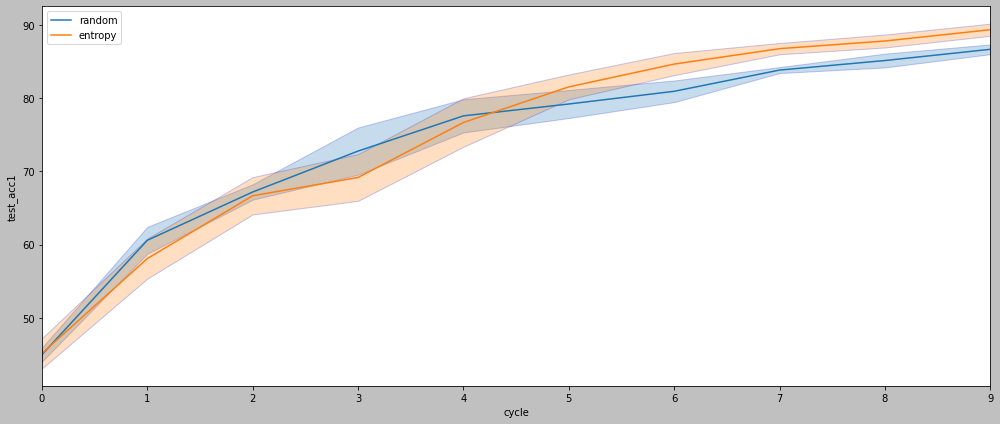

In [49]:
# Choice of Demonstration for test stats

metric = 'test_acc1'
show_std = True

fig = plt.figure(figsize=(14,6), facecolor='silver', edgecolor='black', tight_layout=True)

for model, label in zip(model_names, labels):
    plt.plot(avg_test_metrics[model][metric], label=label)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(avg_test_metrics[model][metric]))], 
            y1=avg_test_metrics[model][metric]+abs(test_stds[model][metric]), 
            y2=avg_test_metrics[model][metric]-abs(test_stds[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='upper left')
plt.xlim(0, len(avg_test_metrics[model][metric])-1)
plt.xlabel('cycle')
plt.ylabel(metric)
plt.show()    

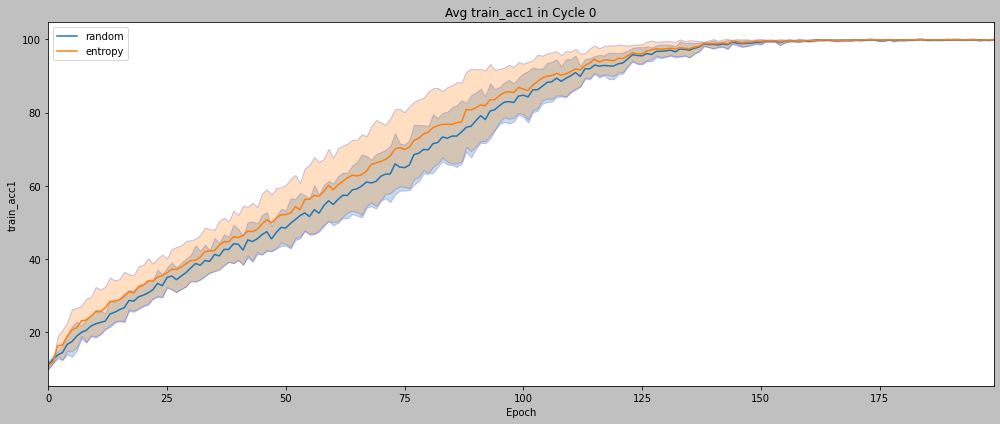

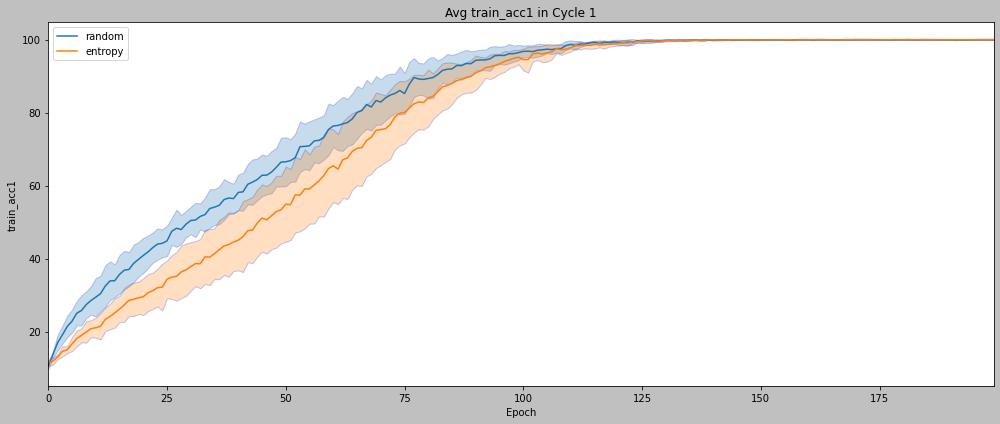

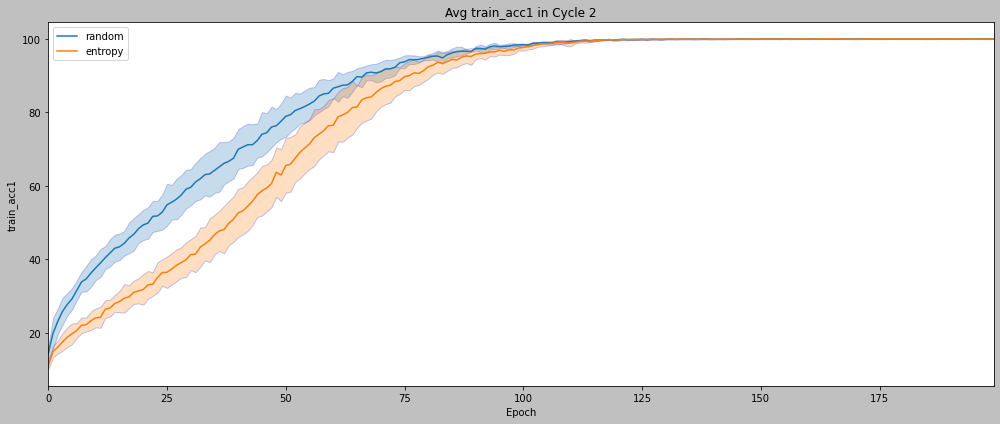

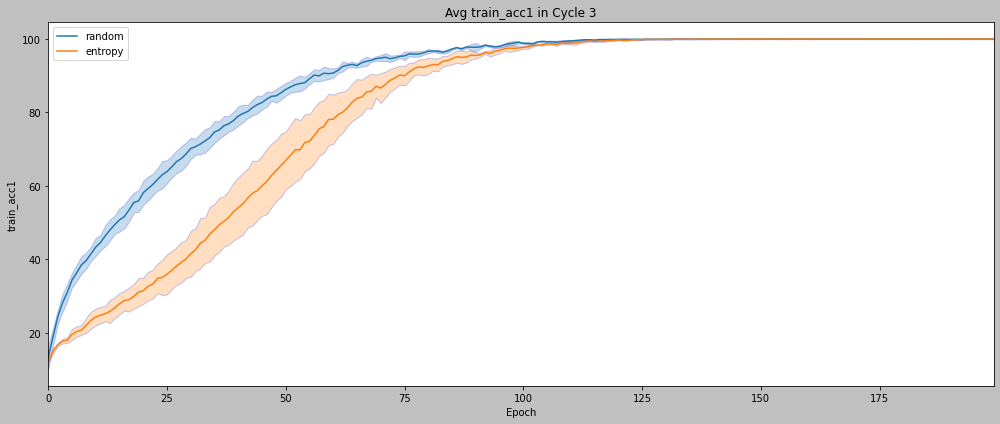

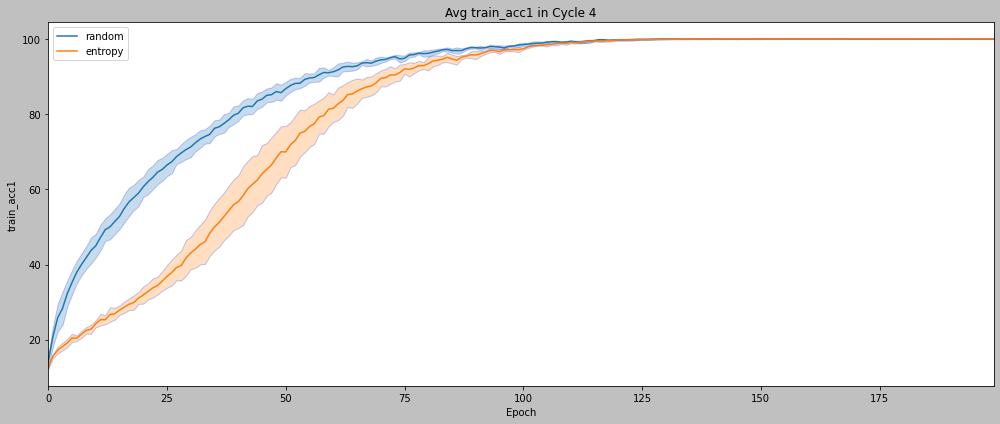

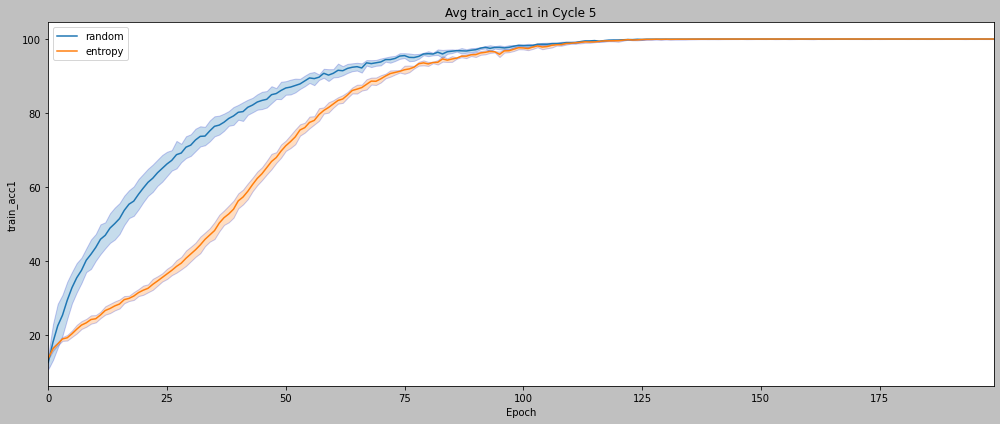

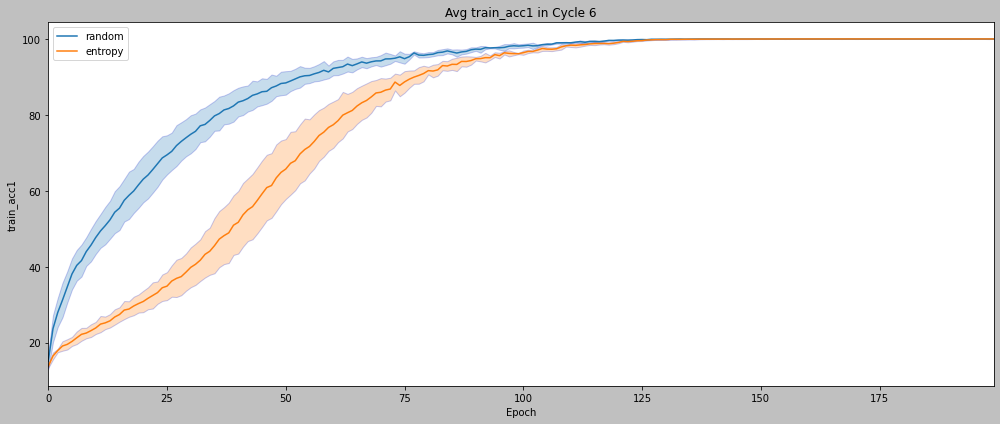

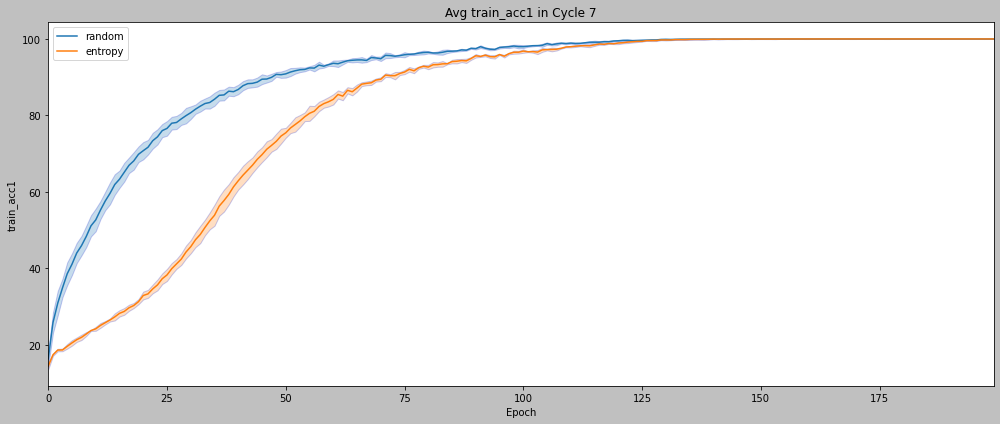

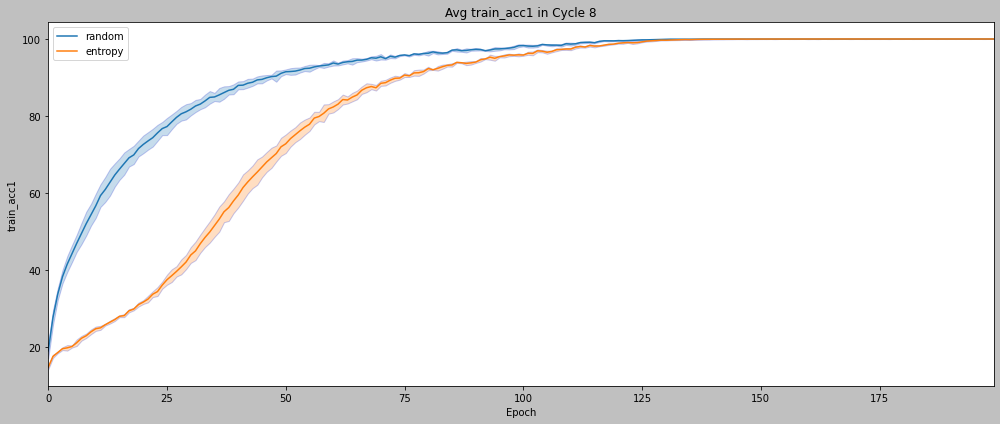

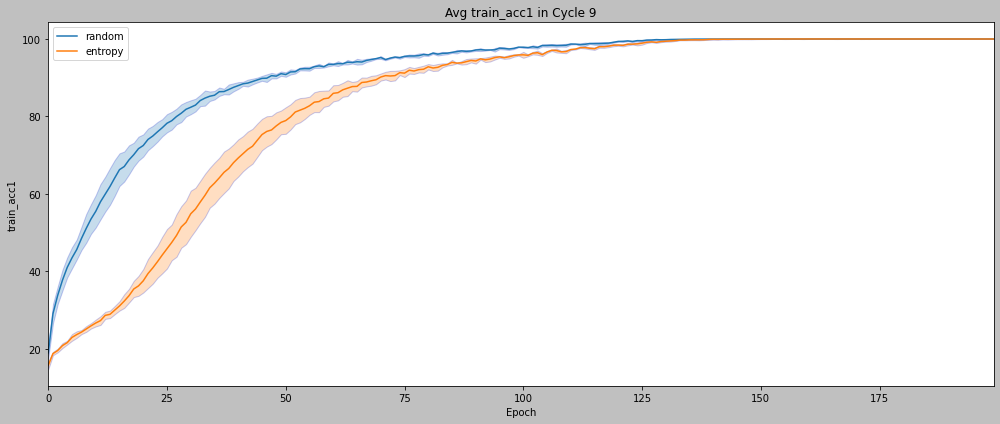

In [52]:
# Choice of Demonstration for train stats

metric = 'train_acc1'
show_std = True

for cycle in range(0,10):
    fig = plt.figure(figsize=(14,6), facecolor='silver', edgecolor='black', tight_layout=True)
    for model, label in zip(model_names, labels):
        plt.plot(avg_train_metrics[model][metric][cycle], label=label)
        if show_std:
            plt.fill_between(
                x=[i for i in range(len(avg_train_metrics[model][metric][cycle]))], 
                y1=avg_train_metrics[model][metric][cycle]+abs(train_stds[model][metric][cycle]), 
                y2=avg_train_metrics[model][metric][cycle]-abs(train_stds[model][metric][cycle]),
                alpha=0.25,
                edgecolor='#1B2ACC', 
                )
    plt.legend(loc='upper left')
    plt.title("Avg "+metric+" in Cycle "+str(cycle))
    plt.xlim(0, len(avg_train_metrics[model][metric][cycle])-1)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.show()

In [53]:
mc_results = {}
paths = sorted(list(root_path.glob("resnet18_mcdropout*")))
for path in tqdm.tqdm(paths):
    with open(path / 'results.json', 'r') as f:
        run_results = json.load(f)
    with open(path / '.hydra/config.yaml') as g:
        conf = yaml.load(g, Loader=yaml.FullLoader)

    mc_results[path.stem[-1]] = {'results': run_results, 'args': conf}

100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


In [57]:
# Calculate average test metrics and stds for each model 

mc_test_metrics = {metr:[] for metr in test_metrics}

for metric in test_metrics:
    all_values = []
    for seed, run in mc_results.items():
        history = run['results']
        values = []
        for cycle in history:
            values.append(cycle['test_stats'][metric])
        all_values.append(values)
    mc_test_metrics[metric] = np.mean(np.array(all_values), axis=0)


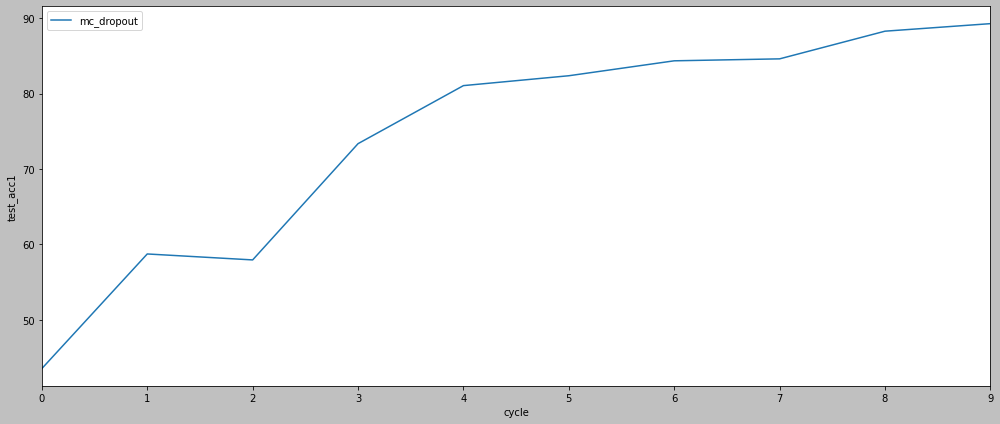

In [58]:
metric = "test_acc1"

fig = plt.figure(figsize=(14,6), facecolor='silver', edgecolor='black', tight_layout=True)

plt.plot(mc_test_metrics[metric], label="mc_dropout")
plt.legend(loc='upper left')
plt.xlim(0, len(mc_test_metrics[metric])-1)
plt.xlabel('cycle')
plt.ylabel(metric)
plt.show()    

In [59]:
mc_train_metrics = {}

for metric in train_metrics:
    all_values = []
    for seed, run in mc_results.items():
        history = run['results']
        values = []
        for cycle in history:
            values.append([stats[metric] for stats in cycle['train_history']])
        all_values.append(values)
    mc_train_metrics[metric] = np.mean(np.array(all_values), axis=0)

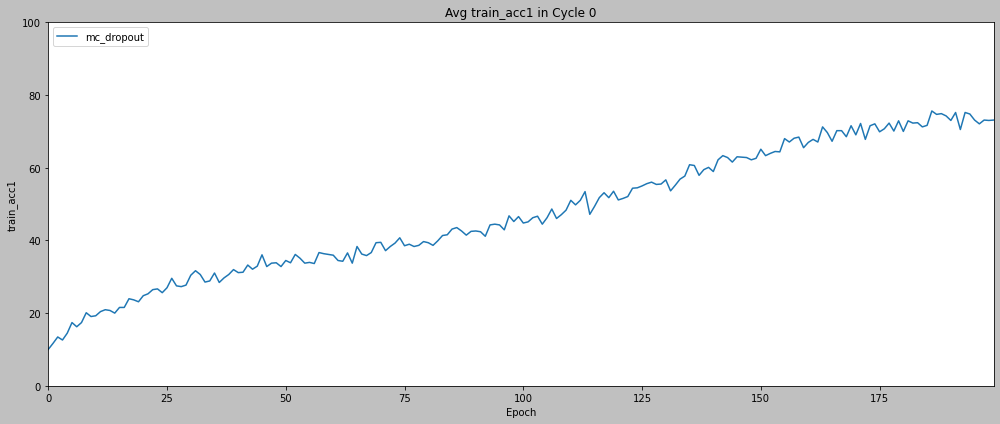

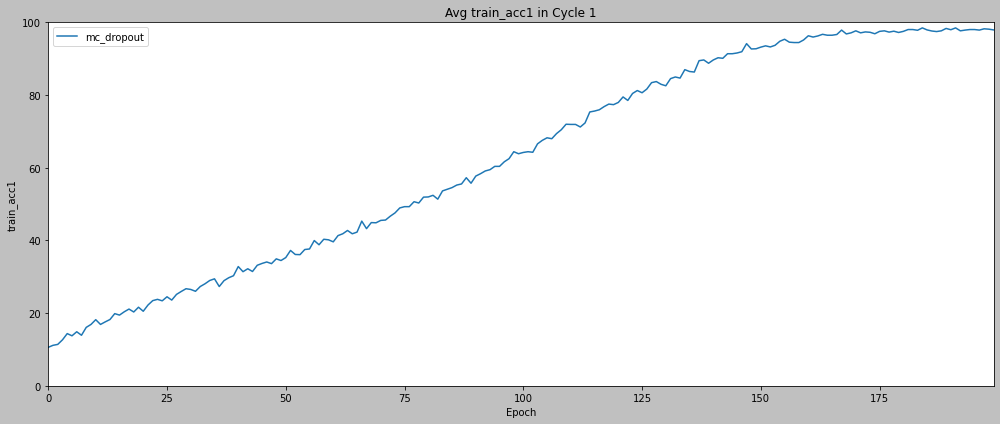

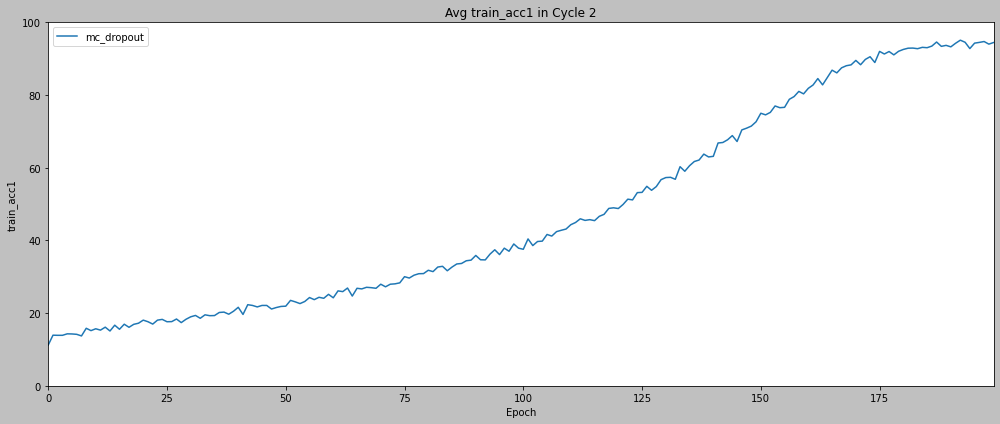

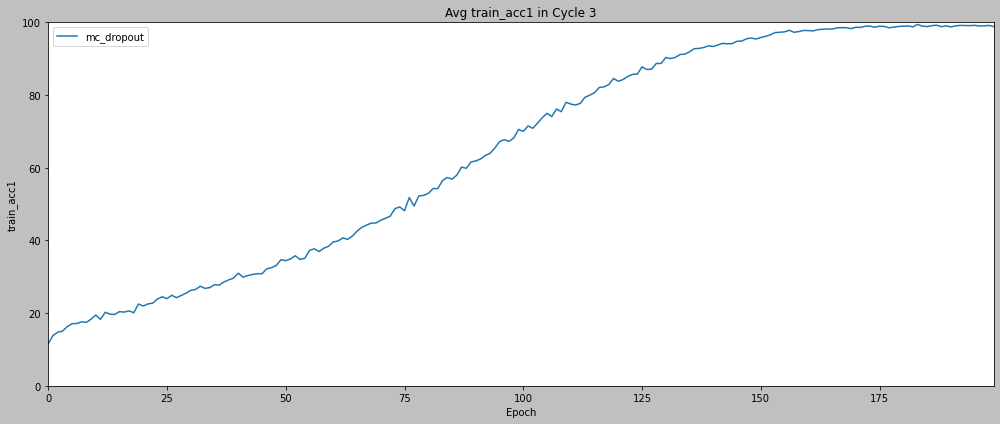

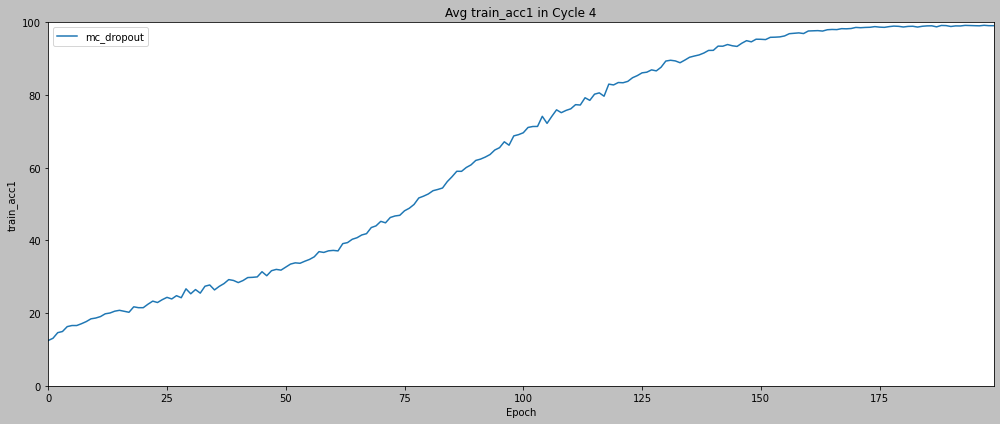

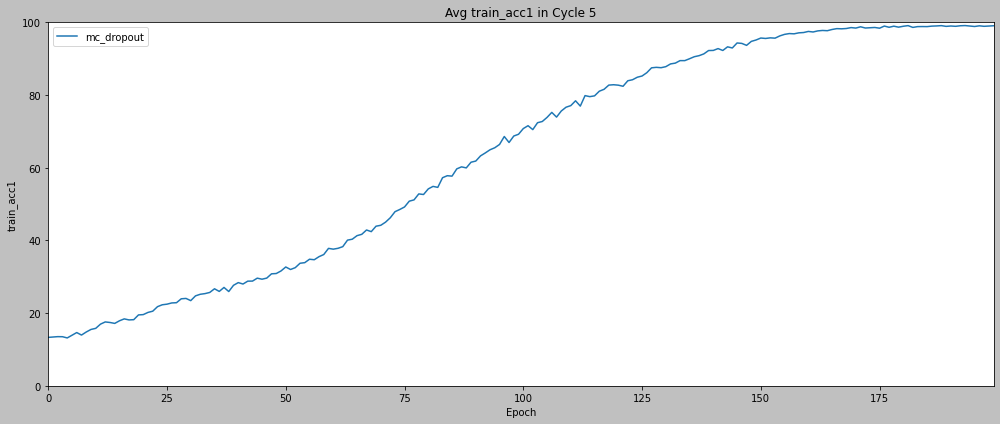

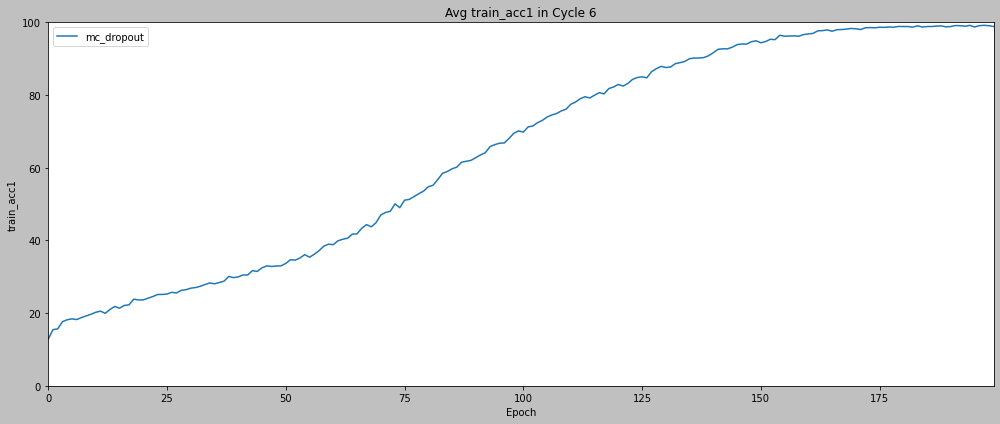

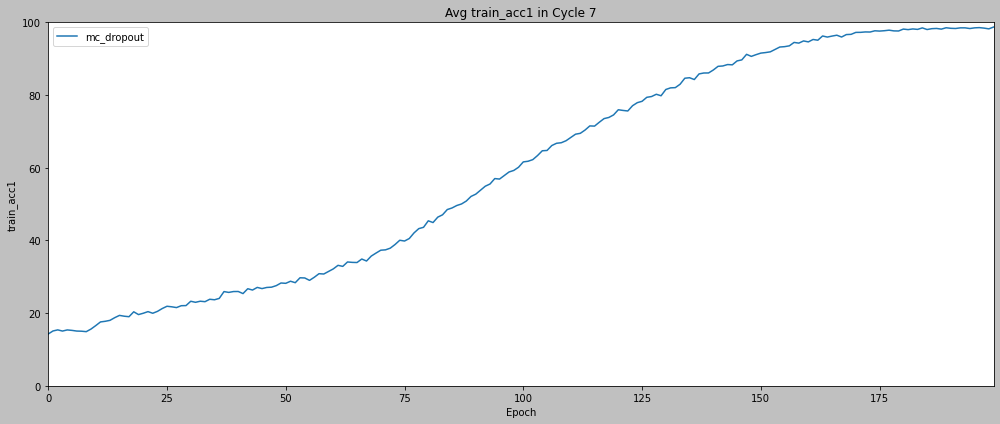

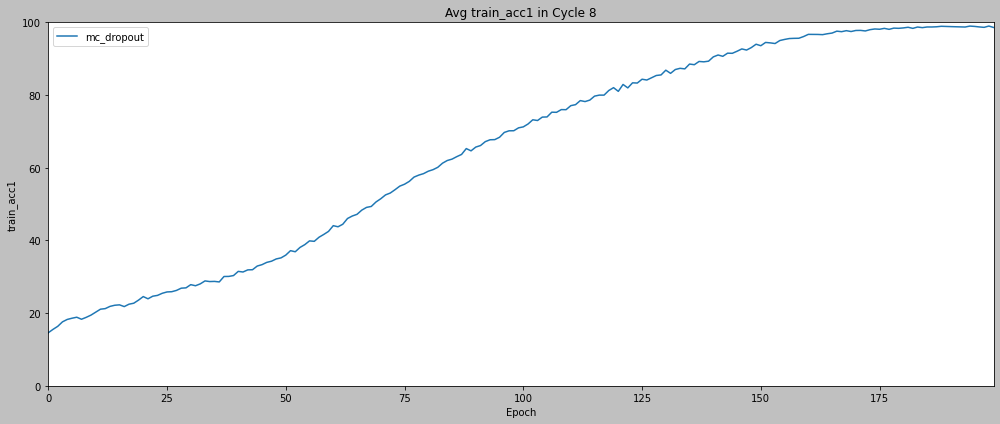

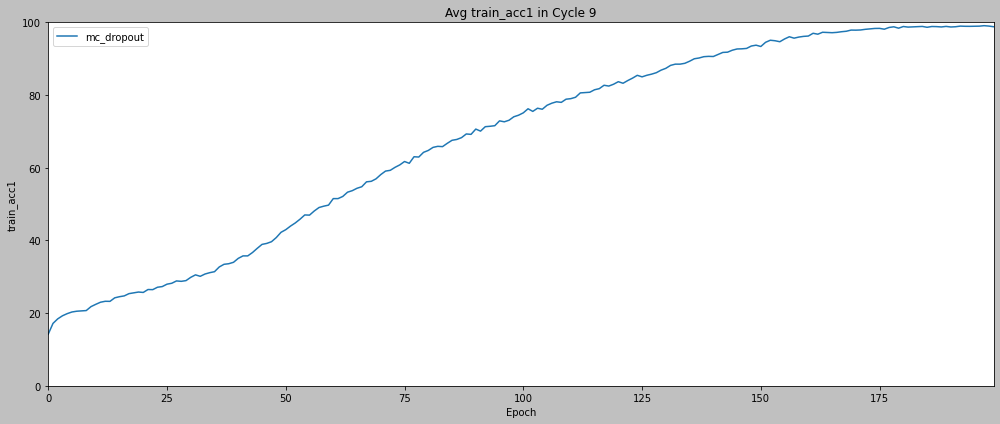

In [61]:
metric = 'train_acc1'

for cycle in range(0,10):
    fig = plt.figure(figsize=(14,6), facecolor='silver', edgecolor='black', tight_layout=True)
    plt.plot(mc_train_metrics[metric][cycle], label="mc_dropout")
    plt.legend(loc='upper left')
    plt.title("Avg "+metric+" in Cycle "+str(cycle))
    plt.xlim(0, len(avg_train_metrics[model][metric][cycle])-1)
    plt.ylim(0, 100)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.show()